In [15]:
from tqdm.notebook import tqdm
from dataclasses import dataclass
from scipy.interpolate import InterpolatedUnivariateSpline
from datetime import datetime, timezone, timedelta
from libWLS import WLS
from kalman_filter import kalman_smoothing
from outlier import exclude_interpolate_outlier
from tqdm.auto import tqdm
from scipy.spatial import distance
from time import time 
from pathlib import Path
import pandas as pd
import pymap3d as pm
import pymap3d.vincenty as pmv
import glob as gl
import numpy as np
import scipy.optimize
import numpy as np  
import pandas as pd 
import os, csv, sys
import glob
import subprocess
import navpy
import matplotlib.pyplot as plt

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

folder_path = os.path.abspath('gnss_analysis')
sys.path.append(folder_path)
from gnssutils import EphemerisManager


In [2]:
path = 'gnss_2024_06_08_13_33_sat.csv'
gnss = pd.read_csv(path, index_col=False)
filtered_gnss = gnss[gnss['ReceivedSvTimeNanos'] > 1e10]
measurement = filtered_gnss

In [3]:
# Lọc các vệ tinh thuộc GPS (ConstellationType == 1)
# Loc cac ve tinh co Multipath
measurement.loc[measurement['ConstellationType'] == 1, 'Constellation'] = 'G'

measurement = measurement.loc[measurement['MultipathIndicator'] == 0]

measurement = measurement.loc[measurement['ReceivedSvTimeUncertaintyNanos'] < 100]

# Chỉ lấy các vệ tinh bắt GPS
measurement = measurement.loc[measurement['Constellation'] == 'G']
# Đảm bảo cột 'Svid' là chuỗi ký tự để có thể sử dụng hàm str.len()
measurement['Svid'] = measurement['Svid'].astype(str)
# Thêm số 0 vào trước 'Svid' nếu chiều dài của nó là 1
measurement.loc[measurement['Svid'].str.len() == 1, 'Svid'] = '0' + measurement['Svid']
# Tạo cột mới 'SvName' bằng cách nối 'Constellation' và 'Svid'
measurement['SvName'] = measurement['Constellation'] + measurement['Svid']

measurement = measurement.loc[measurement['CarrierFrequencyHz'] > 1275420030]

measurement

,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,UnixTime,Epoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond
0,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,3.172665e+06,2.316661e+07,1.233222e+07,-959.735700,-1293.330968,2646.296663,-52632.509136,-0.000409
1,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.331754e+07,5.707099e+06,1.154565e+07,-1431.351931,-270.399831,-2760.800613,69083.457607,-0.006271
2,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.204654e+07,1.257443e+07,2.006245e+07,-2513.489736,-396.867963,-1267.166192,-204091.045800,-0.002522
3,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,9.934963e+06,2.466095e+07,-1.851733e+05,-248.072673,112.356691,-3176.251354,-153573.503054,-0.000954
4,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.231318e+07,2.201891e+07,-8.118271e+06,-855.801316,585.904555,2986.165703,196784.849035,0.000784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-1.265966e+07,2.225182e+07,-6.800616e+06,-734.078065,480.896692,3055.903029,196784.849035,0.000784
3279,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-1.020055e+05,2.359561e+07,-1.250122e+07,-871.665271,1282.795319,2549.497944,50299.903630,0.001261
3280,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-1.981866e+07,1.457240e+07,-9.656602e+06,542.341175,-1115.103159,-2886.661610,147911.675207,0.001602
3281,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-4.598138e+06,1.704565e+07,1.994870e+07,-1640.975864,-1912.081110,1244.910422,112142.916893,-0.000136


In [4]:
#chuyển giá trị thời gian về dạng date time
measurement['UnixTime'] = pd.to_datetime(measurement['utcTimeMillis'],unit='ms', utc=True)
#Chia measurement thành các epoch, mỗi epoch gồm các vệ tinh có cùng thời gian thu
measurement['Epoch'] = 0
measurement.loc[measurement['UnixTime'] - measurement['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
measurement['Epoch'] = measurement['Epoch'].cumsum()
measurement

,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,UnixTime,Epoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond
0,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,3.172665e+06,2.316661e+07,1.233222e+07,-959.735700,-1293.330968,2646.296663,-52632.509136,-0.000409
1,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.331754e+07,5.707099e+06,1.154565e+07,-1431.351931,-270.399831,-2760.800613,69083.457607,-0.006271
2,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.204654e+07,1.257443e+07,2.006245e+07,-2513.489736,-396.867963,-1267.166192,-204091.045800,-0.002522
3,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,9.934963e+06,2.466095e+07,-1.851733e+05,-248.072673,112.356691,-3176.251354,-153573.503054,-0.000954
4,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.231318e+07,2.201891e+07,-8.118271e+06,-855.801316,585.904555,2986.165703,196784.849035,0.000784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-1.265966e+07,2.225182e+07,-6.800616e+06,-734.078065,480.896692,3055.903029,196784.849035,0.000784
3279,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-1.020055e+05,2.359561e+07,-1.250122e+07,-871.665271,1282.795319,2549.497944,50299.903630,0.001261
3280,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-1.981866e+07,1.457240e+07,-9.656602e+06,542.341175,-1115.103159,-2886.661610,147911.675207,0.001602
3281,1717828853000,456707440000000,18,0.0,-1401407364970240967,-0.661142,43.466251,12.293230,12.238130,519.0,...,2024-06-08 06:40:53+00:00,409,-4.598138e+06,1.704565e+07,1.994870e+07,-1640.975864,-1912.081110,1244.910422,112142.916893,-0.000136


In [5]:
# Khởi tạo biến để lưu trữ kết quả
filtered_measurement = pd.DataFrame()

# Duyệt qua từng epoch
for epoch in measurement['Epoch'].unique():
    one_epoch = measurement.loc[measurement['Epoch'] == epoch].drop_duplicates(subset='SvName')
    # Thêm kết quả vào DataFrame kết quả
    filtered_measurement = pd.concat([filtered_measurement, one_epoch])

# Reset index của DataFrame mới
filtered_measurement.reset_index(drop=True, inplace=True)
filtered_measurement = filtered_measurement.groupby('Epoch').apply(lambda x: x.sort_values(by='Svid')).reset_index(drop=True)
measurement = filtered_measurement
measurement.head(20)

C:\Users\luan1\AppData\Local\Temp\ipykernel_1760\2289186973.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_measurement = filtered_measurement.groupby('Epoch').apply(lambda x: x.sort_values(by='Svid')).reset_index(drop=True)


,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,UnixTime,Epoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond
0,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,3.172665e+06,2.316661e+07,1.233222e+07,-959.735700,-1293.330968,2646.296663,-52632.509136,-0.000409
1,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.331754e+07,5.707099e+06,1.154565e+07,-1431.351931,-270.399831,-2760.800613,69083.457607,-0.006271
2,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.204654e+07,1.257443e+07,2.006245e+07,-2513.489736,-396.867963,-1267.166192,-204091.045800,-0.002522
3,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,9.934963e+06,2.466095e+07,-1.851733e+05,-248.072673,112.356691,-3176.251354,-153573.503054,-0.000954
4,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.231318e+07,2.201891e+07,-8.118271e+06,-855.801316,585.904555,2986.165703,196784.849035,0.000784
5,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,2.962953e+05,2.301406e+07,-1.358726e+07,-955.839712,1383.114533,2430.545715,50299.903630,0.001261
6,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.003913e+07,1.502862e+07,-8.379014e+06,467.247485,-977.746041,-2971.691239,147911.675207,0.001602
7,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-3.902532e+06,1.787572e+07,1.936631e+07,-1549.099670,-1893.550942,1425.646937,112142.916893,-0.000136
8,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,1.640842e+07,1.929109e+07,8.095622e+06,240.692187,1076.882136,-2906.633790,149004.896448,0.000170
9,1717828419000,456272440000000,18,0.0,-1401407364970240321,-0.293473,34.072258,14.829616,11.259959,519.0,...,2024-06-08 06:33:39+00:00,1,3.171705e+06,2.316531e+07,1.233487e+07,-959.975916,-1293.567594,2646.030518,-52632.509136,-0.000409


In [6]:
#lấy dữ liệu ephemeris
ephemeris_data_directory = 'output'
manager = EphemerisManager(ephemeris_data_directory)

# while num_sat < 4:
#     one_epoch = measurement.loc[measurement['Epoch'] == epoch].drop_duplicates(subset='SvName')
    
#     if not one_epoch.empty:
#         timestamp = pd.to_datetime(one_epoch.iloc[0]['UnixTime'], unit='s')
#         one_epoch.set_index('SvName', inplace=True)
#         num_sat = len(one_epoch.index)
    
#     epoch += 1

measurement['UnixTime'] = pd.to_datetime(measurement['utcTimeMillis'],unit='ms', utc=True)
timestamps = pd.to_datetime(measurement['UnixTime'].unique(),unit='s')
ephemeris_data = pd.DataFrame()

for timestamp in timestamps:
    # Get satellite names for the current timestamp
    sats = measurement.loc[measurement['UnixTime'] == timestamp, 'SvName'].tolist()
    # Retrieve ephemeris data
    ephemeris = manager.get_ephemeris(timestamp, sats)
    # Append the retrieved ephemeris data to the list
    ephemeris_data = pd.concat([ephemeris_data,ephemeris])

#ephemeris = manager.get_ephemeris(timestamp, sats)
#timestamp
ephemeris_data.reset_index(drop=True, inplace=True)
ephemeris_data.head(20)

Retrieving gnss/data/daily/2024/brdc/brdc1600.24n.gz from https://cddis.nasa.gov/archive/
File downloaded: output\nasa\brdc1600.24n.gz


,time,SVclockBias,SVclockDrift,SVclockDriftRate,IODE,C_rs,deltaN,M_0,C_uc,e,...,L2Pflag,SVacc,health,TGD,IODC,TransTime,FitIntvl,source,t_oc,Leap Seconds
0,2024-06-08 06:00:00+00:00,-0.000176,-1.364242e-12,0.0,101.0,-144.90625,4.036597e-09,-0.948555,-7.236376e-06,0.005900,...,0.0,2.0,0.0,-1.071021e-08,101.0,532818.0,4.0,output\nasa\brdc1600.24n,540000.0,18
1,2024-06-08 06:00:00+00:00,0.000230,-2.091838e-11,0.0,18.0,13.03125,3.965165e-09,2.995210,6.929040e-07,0.002964,...,0.0,2.0,0.0,3.725290e-09,18.0,534432.0,4.0,output\nasa\brdc1600.24n,540000.0,18
2,2024-06-08 06:00:00+00:00,-0.000681,-8.412826e-12,0.0,129.0,8.78125,4.426613e-09,-2.012714,5.420297e-07,0.001338,...,0.0,2.0,0.0,-8.847564e-09,385.0,532818.0,4.0,output\nasa\brdc1600.24n,540000.0,18
3,2024-06-08 06:00:00+00:00,-0.000512,-3.183231e-12,0.0,10.0,27.06250,4.401612e-09,1.383232,1.110137e-06,0.008752,...,0.0,2.0,0.0,-1.257285e-08,10.0,533466.0,4.0,output\nasa\brdc1600.24n,540000.0,18
4,2024-06-08 06:00:00+00:00,0.000656,2.614797e-12,0.0,41.0,-31.00000,4.266606e-09,-1.586018,-1.570210e-06,0.008125,...,0.0,2.0,0.0,-1.117587e-08,41.0,532818.0,4.0,output\nasa\brdc1600.24n,540000.0,18
5,2024-06-08 06:00:00+00:00,0.000168,4.206413e-12,0.0,93.0,-64.90625,4.776270e-09,-2.265936,-3.430992e-06,0.015677,...,0.0,2.0,0.0,-1.024455e-08,93.0,532818.0,4.0,output\nasa\brdc1600.24n,540000.0,18
6,2024-06-08 06:00:00+00:00,0.000493,5.343281e-12,0.0,97.0,143.06250,4.154816e-09,0.667421,7.137656e-06,0.009916,...,0.0,2.0,0.0,-1.536682e-08,97.0,533748.0,4.0,output\nasa\brdc1600.24n,540000.0,18
7,2024-06-08 06:00:00+00:00,0.000374,-4.547474e-13,0.0,71.0,-149.62500,4.444471e-09,-2.886992,-7.638708e-06,0.003581,...,0.0,2.0,0.0,-8.381903e-09,71.0,532818.0,4.0,output\nasa\brdc1600.24n,540000.0,18
8,2024-06-08 06:00:00+00:00,0.000497,5.684342e-13,0.0,40.0,12.37500,4.795200e-09,1.347935,5.606562e-07,0.011622,...,0.0,2.8,0.0,5.122274e-09,40.0,536898.0,4.0,output\nasa\brdc1600.24n,540000.0,18
9,2024-06-08 06:00:00+00:00,-0.000176,-1.364242e-12,0.0,101.0,-144.90625,4.036597e-09,-0.948555,-7.236376e-06,0.005900,...,0.0,2.0,0.0,-1.071021e-08,101.0,532818.0,4.0,output\nasa\brdc1600.24n,540000.0,18


In [7]:
LIGHTSPEED = 2.99792458e8

def calculate_satellite_position(ephemeris, transmit_time):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv']= ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t_k'] = transmit_time - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = M_k + ephemeris['e']*np.sin(E_k)
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    sinE_k = np.sin(E_k)
    cosE_k = np.cos(E_k)
    delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    delT_oc = transmit_time - ephemeris['t_oc']
    sv_position['delT_sv'] = ephemeris['SVclockBias'] + ephemeris['SVclockDrift'] * delT_oc + ephemeris['SVclockDriftRate'] * delT_oc.pow(2)

    v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k,(cosE_k - ephemeris['e']))

    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k

    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k

    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)

    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['z_k'] = y_k_prime*np.sin(i_k)
    sv_position['SvClockBiasMeters'] = ephemeris['SVclockBias'] * LIGHTSPEED
    sv_position['SvClockDriftMetersPerSecond'] = ephemeris['SVclockDrift'] * LIGHTSPEED

    #calculate velocity
    Edot_k = n_0/(1-ephemeris['e']*np.cos(E_k))
    
    vdot_k = Edot_k * np.sqrt(1 - ephemeris['e']**2)/(1 - ephemeris['e']*np.cos(E_k))
    
    d_idotk = ephemeris['IDOT'] + 2 * vdot_k * (ephemeris['C_is'] * cos2Phi_k - ephemeris['C_ic']*sin2Phi_k)
    
    udot_k = vdot_k + 2 * vdot_k * (ephemeris['C_us']*cos2Phi_k - ephemeris['C_uc']*sin2Phi_k)
    
    rdot_k = ephemeris['e'] * A * Edot_k * np.sin(E_k) + 2 * vdot_k * (ephemeris['C_rs'] * cos2Phi_k - ephemeris['C_rc'] * sin2Phi_k)
    
    Omegadot_k = ephemeris['OmegaDot'] - OmegaDot_e
    
    x_plus_dot_k = rdot_k * np.cos(u_k) - r_k * udot_k*np.sin(u_k)
    y_plus_dot_k = rdot_k * np.sin(u_k) + r_k * udot_k*np.cos(u_k)
    
    sv_position['v_x'] = -x_k_prime * Omegadot_k * np.sin(Omega_k) + x_plus_dot_k * np.cos(Omega_k) - y_plus_dot_k * np.sin(Omega_k)*np.cos(i_k) - y_k_prime * (Omegadot_k * np.cos(Omega_k) * np.cos(i_k) - d_idotk * np.sin(Omega_k)*np.sin(i_k))
    
    sv_position['v_y'] = x_k_prime * Omegadot_k * np.cos(Omega_k) + x_plus_dot_k * np.sin(Omega_k) + y_plus_dot_k * np.cos(Omega_k)*np.cos(i_k) - y_k_prime * (Omegadot_k * np.sin(Omega_k) * np.cos(i_k) + d_idotk * np.cos(Omega_k)*np.sin(i_k))
    
    sv_position['v_z'] = y_plus_dot_k * np.sin(i_k) + y_k_prime * d_idotk * np.cos(i_k)

    return sv_position

# Run the function and check out the results:
measurement['ReceivedSvTimeNanos'] = pd.to_numeric(measurement['ReceivedSvTimeNanos'])
measurement['TimeOffsetNanos'] = pd.to_numeric(measurement['TimeOffsetNanos'])
sv_position = calculate_satellite_position(ephemeris_data, (measurement['ReceivedSvTimeNanos'] + measurement['TimeOffsetNanos'])*1e-9)
#xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()
measurement['SvPositionXEcefMeters'] = sv_position['x_k']
measurement['SvPositionYEcefMeters'] = sv_position['y_k']
measurement['SvPositionZEcefMeters'] = sv_position['z_k']
measurement['SvVelocityXEcefMetersPerSecond'] = sv_position['v_x']
measurement['SvVelocityYEcefMetersPerSecond'] = sv_position['v_y']
measurement['SvVelocityZEcefMetersPerSecond'] = sv_position['v_z']
measurement['SvClockBiasMeters'] = sv_position['SvClockBiasMeters']
measurement['SvClockDriftMetersPerSecond'] = sv_position['SvClockDriftMetersPerSecond']
measurement.head(20)

,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,UnixTime,Epoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond
0,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,3.172665e+06,2.316661e+07,1.233222e+07,-959.735700,-1293.330968,2646.296663,-52632.509136,-0.000409
1,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.331754e+07,5.707099e+06,1.154565e+07,-1431.351931,-270.399831,-2760.800613,69083.457607,-0.006271
2,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.204654e+07,1.257443e+07,2.006245e+07,-2513.489736,-396.867963,-1267.166192,-204091.045800,-0.002522
3,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,9.934963e+06,2.466095e+07,-1.851733e+05,-248.072673,112.356691,-3176.251354,-153573.503054,-0.000954
4,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.231318e+07,2.201891e+07,-8.118271e+06,-855.801316,585.904555,2986.165703,196784.849035,0.000784
5,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,2.962953e+05,2.301406e+07,-1.358726e+07,-955.839712,1383.114533,2430.545715,50299.903630,0.001261
6,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.003913e+07,1.502862e+07,-8.379014e+06,467.247485,-977.746041,-2971.691239,147911.675207,0.001602
7,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-3.902532e+06,1.787572e+07,1.936631e+07,-1549.099670,-1893.550942,1425.646937,112142.916893,-0.000136
8,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,1.640842e+07,1.929109e+07,8.095622e+06,240.692187,1076.882136,-2906.633790,149004.896448,0.000170
9,1717828419000,456272440000000,18,0.0,-1401407364970240321,-0.293473,34.072258,14.829616,11.259959,519.0,...,2024-06-08 06:33:39+00:00,1,3.171705e+06,2.316531e+07,1.233487e+07,-959.975916,-1293.567594,2646.030518,-52632.509136,-0.000409


In [8]:
measurement.to_csv('gnss_sat.csv')

In [9]:
epoch = 0
num_sat = 0

while num_sat < 4:
    one_epoch = measurement.loc[measurement['Epoch'] == epoch]
    if not one_epoch.empty:
        one_epoch.set_index('SvName', inplace=True)
        num_sat = len(one_epoch.index)
    epoch += 1
one_epoch

,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,UnixTime,Epoch,SvPositionXEcefMeters,SvPositionYEcefMeters,SvPositionZEcefMeters,SvVelocityXEcefMetersPerSecond,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond
SvName,,,,,,,,,,,,,,,,,,,,,
G05,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,3.172665e+06,2.316661e+07,1.233222e+07,-959.735700,-1293.330968,2646.296663,-52632.509136,-0.000409
G06,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.331754e+07,5.707099e+06,1.154565e+07,-1431.351931,-270.399831,-2760.800613,69083.457607,-0.006271
G11,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.204654e+07,1.257443e+07,2.006245e+07,-2513.489736,-396.867963,-1267.166192,-204091.045800,-0.002522
G12,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,9.934963e+06,2.466095e+07,-1.851733e+05,-248.072673,112.356691,-3176.251354,-153573.503054,-0.000954
G13,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-1.231318e+07,2.201891e+07,-8.118271e+06,-855.801316,585.904555,2986.165703,196784.849035,0.000784
G15,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,2.962953e+05,2.301406e+07,-1.358726e+07,-955.839712,1383.114533,2430.545715,50299.903630,0.001261
G19,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-2.003913e+07,1.502862e+07,-8.379014e+06,467.247485,-977.746041,-2971.691239,147911.675207,0.001602
G20,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,-3.902532e+06,1.787572e+07,1.936631e+07,-1549.099670,-1893.550942,1425.646937,112142.916893,-0.000136
G25,1717828418000,456271440000000,18,0.0,-1401407364970240336,-0.447954,37.172242,13.190644,13.193295,519.0,...,2024-06-08 06:33:38+00:00,0,1.640842e+07,1.929109e+07,8.095622e+06,240.692187,1076.882136,-2906.633790,149004.896448,0.000170


In [10]:
# Bắt đầu từ đây là đoạn mã xử lý dữ liệu đã tìm được
wls = WLS()
ecef_list = []
utcTimeMillis_list = []  # Danh sách để lưu giữ utcTimeMillis tương ứng

for epoch in measurement['Epoch'].unique():
    one_epoch = measurement.loc[(measurement['Epoch'] == epoch)]
    if len(one_epoch.index) > 4:
        try:
            x_wls, v_wls, cov_x, cov_v = wls.WLS_onePosition(one_epoch)  # epoch like period 1s,10s or ....
            ecef_list.append((x_wls, v_wls, cov_x, cov_v))  # unit m, m/s and use tuple to store nhiều variable
            utcTimeMillis_list.append(one_epoch['utcTimeMillis'].iloc[0])  # Lấy giá trị utcTimeMillis đầu tiên cho epoch này
        except Exception as e:
            print(f"Error in WLS_onePosition for epoch {epoch}: {e}")

# Kiểm tra danh sách `utcTimeMillis_list` và `ecef_list`
assert len(utcTimeMillis_list) == len(ecef_list), "The lengths of utcTimeMillis_list and ecef_list do not match"

# Nếu các mảng có kích thước phù hợp, ta có thể stack chúng lại
x_wls_array = np.array([x[0] for x in ecef_list])
if len(x_wls_array) == 0:
    raise ValueError("x_wls_array is empty")

# In ra độ dài của các mảng để kiểm tra
print(f"Length of x_wls_array: {len(x_wls_array)}")
print(f"Length of utcTimeMillis_list: {len(utcTimeMillis_list)}")

# Chuyển đổi từ ECEF sang tọa độ địa lý (latitude, longitude, altitude)
try:
    lla_array = navpy.ecef2lla(x_wls_array.T)
    lla_array = np.array(lla_array).T  # Chuyển đổi thành mảng numpy và chuyển vị
except Exception as e:
    raise ValueError(f"Error in converting ECEF to LLA: {e}")

# In ra độ dài của mảng lla_array để kiểm tra
print(f"Length of lla_array: {len(lla_array)}")

# Kiểm tra kích thước của `lla_array` và `utcTimeMillis_list`
assert len(lla_array) == len(utcTimeMillis_list), "The lengths of lla_array and utcTimeMillis_list do not match"

# Tạo DataFrame và lưu thành file CSV
position_array = [(time, lat, lon) for time, (lat, lon, alt) in zip(utcTimeMillis_list, lla_array)]
lla_df = pd.DataFrame(position_array, columns=['Time', 'Latitude', 'Longitude'])
lla_df.to_csv('calculated_position_wls.csv', index=False)

print(lla_df.head())


Length of x_wls_array: 395
Length of utcTimeMillis_list: 395
Length of lla_array: 395
            Time   Latitude   Longitude
0  1717828418000  21.005265  105.846028
1  1717828419000  21.004643  105.846154
2  1717828421000  21.005130  105.846473
3  1717828422000  21.004625  105.846381
4  1717828423000  21.005422  105.846170


In [11]:
# # Kalman Filter
# # Transistion ecef_list to each array numpy 
# x_wls = np.array([x[0] for x in ecef_list])
# v_wls = np.array([x[1] for x in ecef_list])
# cov_x = np.array([x[2] for x in ecef_list])
# cov_v = np.array([x[3] for x in ecef_list])
# x_kf, P_f = kalman_smoothing(x_wls, v_wls, cov_x, cov_v)
# ecef_list.append(x_kf)
# print(x_kf)  
# Kiểm tra và chuẩn hóa kích thước của các phần tử trong ecef_list
# max_len = max(len(x[0]) for x in ecef_list)

# # Hàm để chuẩn hóa kích thước của một phần tử
# def pad_to_max_len(array, max_len):
#     if len(array) < max_len:
#         pad_width = max_len - len(array)
#         array = np.pad(array, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
#     return array

# ecef_list_padded = [(pad_to_max_len(x[0], max_len), pad_to_max_len(x[1], max_len), pad_to_max_len(x[2], max_len), pad_to_max_len(x[3], max_len)) for x in ecef_list]

# Chuyển đổi ecef_list thành các mảng numpy riêng lẻ
# x_wls = np.array([x[0] for x in ecef_list_padded])
# v_wls = np.array([x[1] for x in ecef_list_padded])
# cov_x = np.array([x[2] for x in ecef_list_padded])
# cov_v = np.array([x[3] for x in ecef_list_padded])

# x_wls = np.array([x[0] for x in ecef_list])
# v_wls = np.array([x[1] for x in ecef_list])
# cov_x = np.array([x[2] for x in ecef_list])
# cov_v = np.array([x[3] for x in ecef_list])
# # Áp dụng Kalman Filter
# x_kf, P_f = kalman_smoothing(x_wls, v_wls, cov_x, cov_v)
# ecef_list.append(x_kf)
# print(x_kf, P_f)  # In ra giá trị ước lượng vị trí



In [13]:

# Kiểm tra cấu trúc dữ liệu trong ecef_list và loại bỏ các epoch có kích thước không đồng nhất
filtered_ecef_list = []
filtered_utcTimeMillis_list = []

for i, ecef in enumerate(ecef_list):
    if ecef[2].shape == (3, 3) and ecef[3].shape == (3, 3):
        filtered_ecef_list.append(ecef)
        filtered_utcTimeMillis_list.append(utcTimeMillis_list[i])
    else:
        print(f"Skipping Epoch {i} due to inconsistent shape: cov_x shape = {ecef[2].shape}, cov_v shape = {ecef[3].shape}")

# Nếu các mảng có kích thước phù hợp, ta có thể stack chúng lại
x_wls = np.array([x[0] for x in filtered_ecef_list])
v_wls = np.array([x[1] for x in filtered_ecef_list])
cov_x = np.array([x[2] for x in filtered_ecef_list])
cov_v = np.array([x[3] for x in filtered_ecef_list])

# Áp dụng Kalman Filter
try:
    x_wls, v_wls, cov_x, cov_v = exclude_interpolate_outlier(x_wls, v_wls, cov_x, cov_v)
    x_kf, P_f = kalman_smoothing(x_wls, v_wls, cov_x, cov_v)
    # print(x_kf, P_f)  # In ra giá trị ước lượng vị trí

    # Chuyển đổi kết quả Kalman Filter từ ECEF sang tọa độ địa lý
    try:
        lla_kf = navpy.ecef2lla(x_kf.T)
        lla_kf = np.array(lla_kf).T  # Chuyển đổi thành mảng numpy và chuyển vị
    except Exception as e:
        raise ValueError(f"Error in converting ECEF to LLA for Kalman Filter results: {e}")

    # Tạo DataFrame và in ra kết quả Time, Latitude, Longitude sau khi áp dụng Kalman Filter
    kf_position_array = [(time, lat, lon) for time, (lat, lon, alt) in zip(filtered_utcTimeMillis_list, lla_kf)]
    kf_df = pd.DataFrame(kf_position_array, columns=['utcTimeMillis', 'Latitude', 'Longitude'])
    print(kf_df.head())

    # Lưu kết quả sau khi áp dụng Kalman Filter thành file CSV
    kf_df.to_csv('kf_position_data.csv', index=False)
except Exception as e:
    print(f"Error during Kalman Filter application: {e}")


   utcTimeMillis   Latitude   Longitude
0  1717828418000  21.005265  105.846028
1  1717828419000  21.005268  105.846091
2  1717828421000  21.005165  105.846227
3  1717828422000  21.005164  105.846289
4  1717828423000  21.005177  105.846326


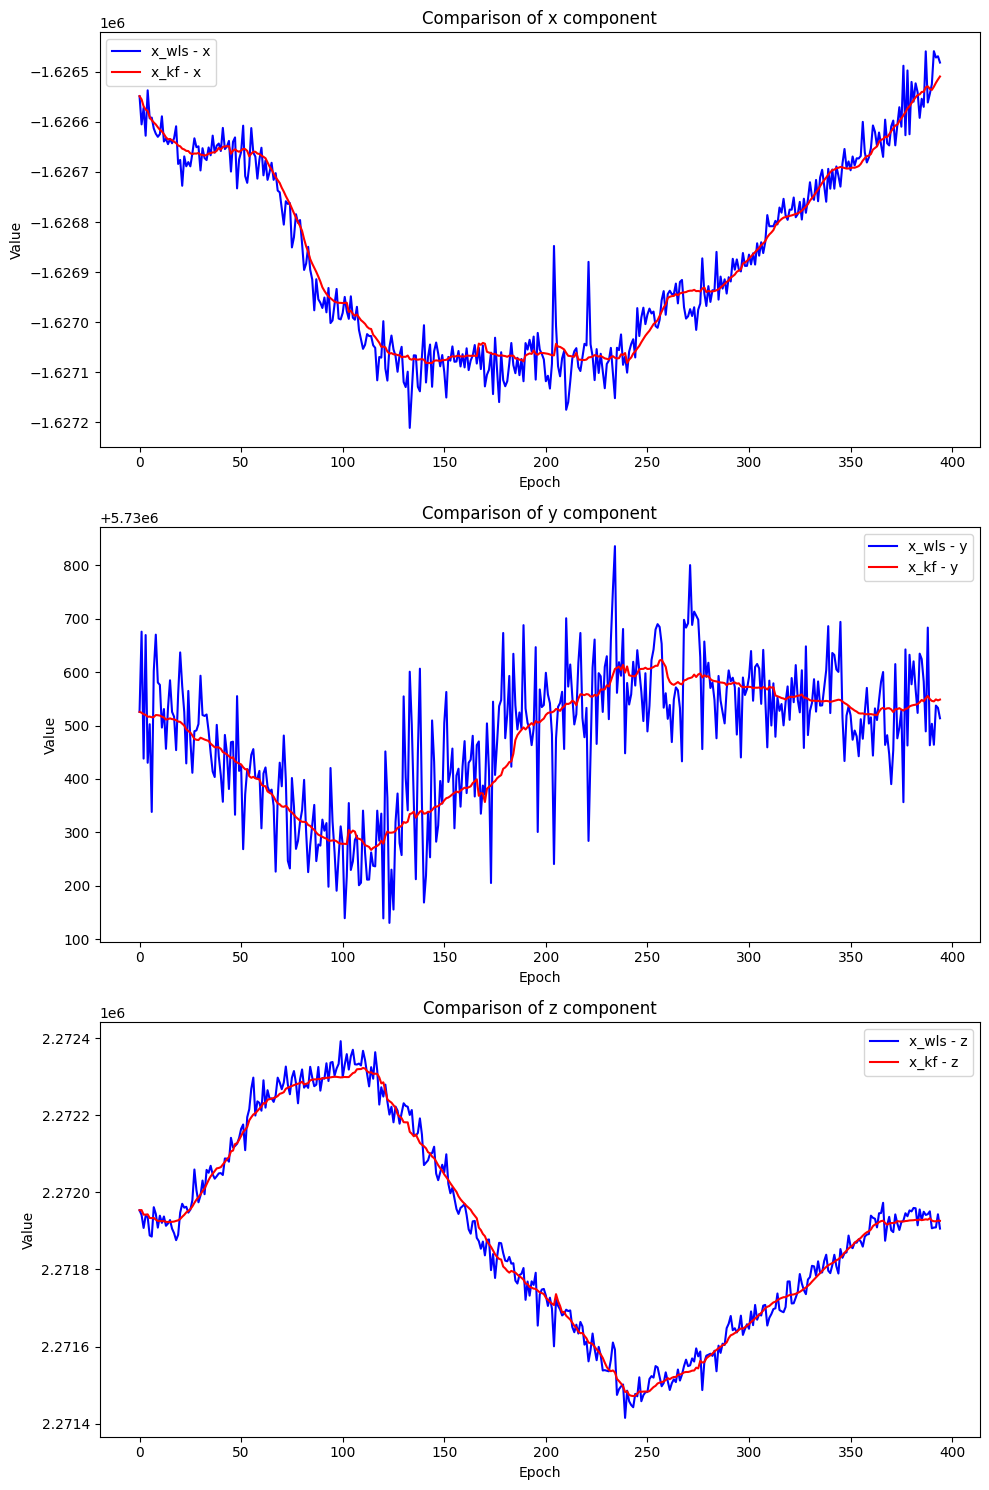

In [16]:
# Tách các thành phần x, y, z
x_wls_x, x_wls_y, x_wls_z = x_wls[:, 0], x_wls[:, 1], x_wls[:, 2]
x_kf_x, x_kf_y, x_kf_z = x_kf[:, 0], x_kf[:, 1], x_kf[:, 2]
# Vẽ biểu đồ so sánh
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Biểu đồ cho x
axs[0].plot(x_wls_x, label='x_wls - x', color='blue')
axs[0].plot(x_kf_x, label='x_kf - x', color='red')
axs[0].set_title('Comparison of x component')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].legend()

# Biểu đồ cho y
axs[1].plot(x_wls_y, label='x_wls - y', color='blue')
axs[1].plot(x_kf_y, label='x_kf - y', color='red')
axs[1].set_title('Comparison of y component')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].legend()

# Biểu đồ cho z
axs[2].plot(x_wls_z, label='x_wls - z', color='blue')
axs[2].plot(x_kf_z, label='x_kf - z', color='red')
axs[2].set_title('Comparison of z component')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Value')
axs[2].legend()

plt.tight_layout()
plt.show()